In [21]:
import os
import gc
import numpy as np
from utils import *
import pandas as pd
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score
%run skills.ipynb
%run languages.ipynb
%run work_experiences.ipynb

class config:
    path = '../../../datasets/garanti-bbva-data-camp/'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/languages.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6

In [22]:
train_df = pd.read_csv(os.path.join(config.path, 'train_users.csv'))
test_df = pd.read_csv(os.path.join(config.path, 'test_users.csv'))
sub = pd.read_csv(config.sub_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')

train_df shape: (53019, 4)
test_df shape: (13255, 3)


In [23]:
df = train_df.append(test_df)

df.head()

,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0
2,4880,Online Media,Turkey,0.0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0
4,11005,Banking,"Istanbul, Turkey",0.0


In [24]:
def fix_location(dataframe: pd.DataFrame) -> pd.DataFrame:

    df_ = dataframe.copy()
    df_['location'] = df_['location'].astype(str)
    df_['location'] = df_['location'].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_['location'] = df_['location'].apply(lambda x: x.upper().strip())
    df_['location'] = df_['location'].apply(lambda x: translation(str(x)))
    tr_cities = load_tr_cities()
    for city in tr_cities:
        df_['location'] = df_['location'].apply(lambda x: city if city in x else x)

    return df_

In [25]:
df = fix_location(df)

skills_df = load_skills(config.skills_path, 30)
lang_df = load_languages(config.languages_path)
#exp_df = load_work_experiences(config.exp_path)

df = df.merge(skills_df, on = ['user_id'], how = 'left')
df = df.merge(lang_df, on = ['user_id'], how = 'left')
#df = df.merge(exp_df, on = ['user_id'], how = 'left')

print(df.shape)
df.head()

Frequency of top 20 skills before preprocess: 294433
Frequency of top 20 skills after preprocess: 318624


100%|██████████| 12/12 [00:01<00:00,  7.57it/s]


(66274, 47)


,user_id,industry,location,moved_after_2019,skill_Java,skill_JavaScript,skill_SQL,skill_C#,skill_Software Development,skill_HTML,...,language_French,language_Spanish,language_Russian,language_Arabic,language_Italian,language_Japanese,language_Azerbaijani,language_Chinese,language_Korean,total_languages
0,1301,Information Technology and Services,ISTANBUL,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,6950,Internet,ISTANBUL,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0
2,4880,Online Media,TURKEY,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26046,Telecommunications,ISTANBUL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,11005,Banking,ISTANBUL,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [26]:
target = 'moved_after_2019'
cat_features = ['industry', 'location']
drop_features = ['user_id']

for caterogical_col in cat_features:
    df[caterogical_col] = df[caterogical_col].astype(str).astype("category")

train_set = df.loc[df[target].notnull()].drop(columns=drop_features, axis = 1)
test_set = df.loc[df[target].isnull()].drop(columns=drop_features, axis = 1)

print(f'train_set: {train_set.shape}')
print(f'test_set: {test_set.shape}')

train_set: (53019, 46)
test_set: (13255, 46)


In [27]:
params = {'subsample': 0.8,
          'bootstrap_type':'Bernoulli',
          'depth': 9,
          'one_hot_max_size': 150}

params['verbose'] = False
params['random_state'] = config.seed
params['cat_features'] = cat_features
params['eval_metric'] = 'Accuracy'
params['allow_writing_files'] = False
params["iterations"] = 5000

kf = KFold(n_splits=config.n_folds)


In [28]:
X = train_set.drop(columns=[target], axis=1)
y = train_set[target]
features = X.columns

X_test = test_set.drop(columns=[target], axis=1)
y_oof = np.zeros(X.shape[0])
y_pred = np.zeros(X_test.shape[0])

-----------------------------------| Fold 1 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6291703	test: 0.6273622	best: 0.6273622 (0)	total: 23.1ms	remaining: 1m 55s
200:	learn: 0.7152234	test: 0.6597262	best: 0.6601788 (183)	total: 2.25s	remaining: 53.7s
400:	learn: 0.7467068	test: 0.6737581	best: 0.6746633 (386)	total: 4.47s	remaining: 51.3s
600:	learn: 0.7685483	test: 0.6837162	best: 0.6838294 (598)	total: 6.69s	remaining: 49s
800:	learn: 0.7830564	test: 0.6868847	best: 0.6868847 (800)	total: 8.9s	remaining: 46.7s
1000:	learn: 0.7943054	test: 0.6881295	best: 0.6890347 (958)	total: 11.1s	remaining: 44.4s
1200:	learn: 0.8058712	test: 0.6914111	best: 0.6925427 (1198)	total: 13.4s	remaining: 42.2s
1400:	learn: 0.8160789	test: 0.6939006	best: 0.6946928 (1377)	total: 15.6s	remaining: 40s
1600:	learn: 0.8251324	test: 0.6988797	best: 0.6991060 (1599)	total: 17.8s	remaining: 37.7s
1800:	learn: 0.8335748	test: 0.7021614	best: 0.7023877 (1799)	total: 20.1s	rema

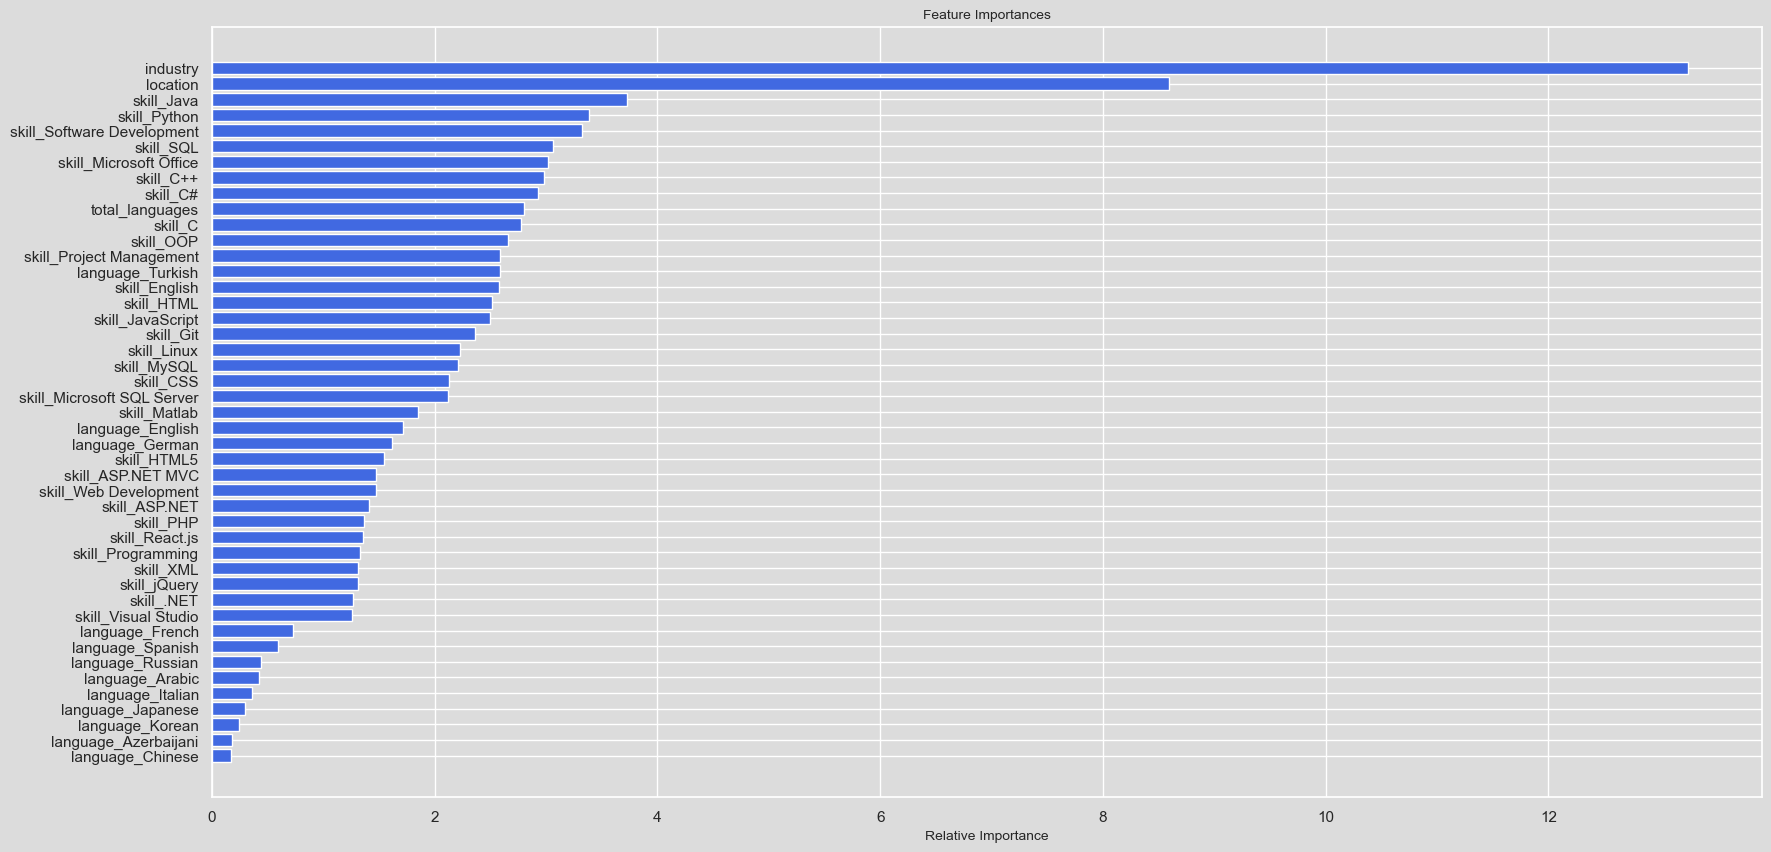

accuracy_score: 0.7163064388367093
-----------------------------------| Fold 2 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6283328	test: 0.6287202	best: 0.6287202 (0)	total: 13.8ms	remaining: 1m 9s
200:	learn: 0.7143407	test: 0.6602920	best: 0.6608578 (179)	total: 2.35s	remaining: 56s
400:	learn: 0.7453035	test: 0.6742107	best: 0.6750028 (386)	total: 4.65s	remaining: 53.3s
600:	learn: 0.7643158	test: 0.6812267	best: 0.6816793 (598)	total: 6.88s	remaining: 50.4s
800:	learn: 0.7798651	test: 0.6859794	best: 0.6860926 (798)	total: 9.13s	remaining: 47.9s
1000:	learn: 0.7926531	test: 0.6902795	best: 0.6909585 (969)	total: 11.4s	remaining: 45.4s
1200:	learn: 0.8029967	test: 0.6934480	best: 0.6949191 (1193)	total: 13.6s	remaining: 42.9s
1400:	learn: 0.8141551	test: 0.6970691	best: 0.6983139 (1398)	total: 15.9s	remaining: 40.8s
1600:	learn: 0.8245213	test: 0.7014824	best: 0.7014824 (1600)	total: 18.2s	remaining: 38.5s
1800:	learn: 0.8316962	test: 0.7025008	bes

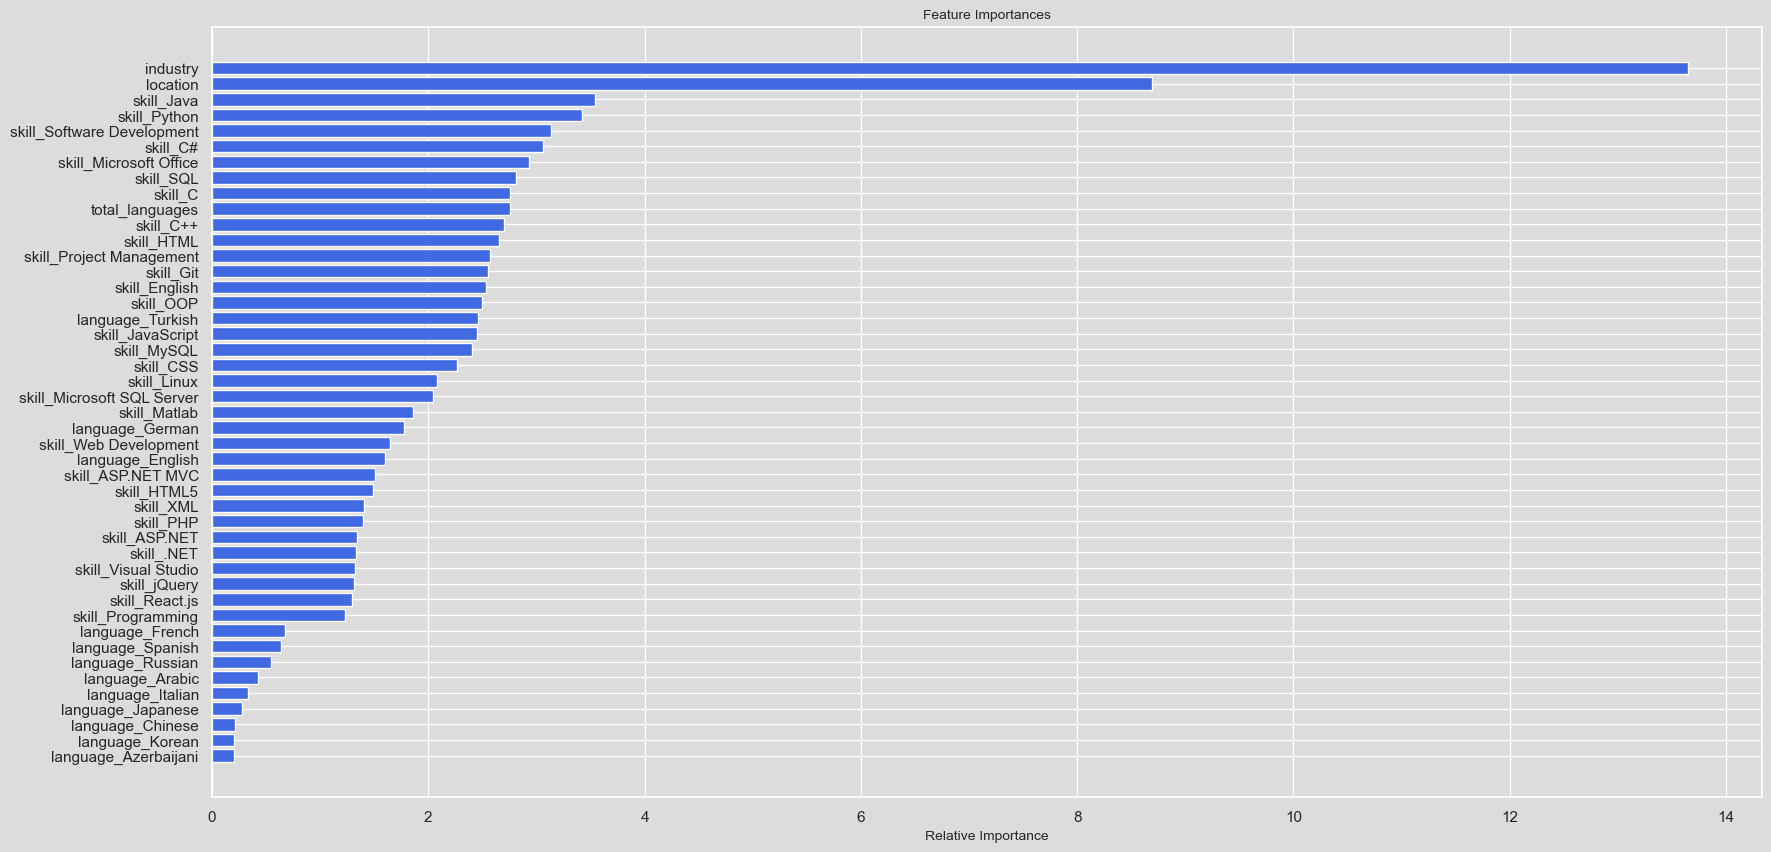

accuracy_score: 0.7131379427407492
-----------------------------------| Fold 3 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6299398	test: 0.6202331	best: 0.6202331 (0)	total: 17.7ms	remaining: 1m 28s
200:	learn: 0.7168304	test: 0.6610841	best: 0.6622157 (182)	total: 2.44s	remaining: 58.2s
400:	learn: 0.7490381	test: 0.6713817	best: 0.6716080 (398)	total: 4.92s	remaining: 56.4s
600:	learn: 0.7685483	test: 0.6806609	best: 0.6808872 (579)	total: 7.26s	remaining: 53.2s
800:	learn: 0.7824906	test: 0.6863189	best: 0.6864320 (771)	total: 9.53s	remaining: 50s
1000:	learn: 0.7963198	test: 0.6945796	best: 0.6952586 (989)	total: 12.4s	remaining: 49.3s
1200:	learn: 0.8082251	test: 0.6978613	best: 0.6980876 (1160)	total: 14.5s	remaining: 45.9s
1400:	learn: 0.8165769	test: 0.6955981	best: 0.6980876 (1160)	total: 16.8s	remaining: 43.3s
1600:	learn: 0.8252456	test: 0.6993324	best: 0.7000113 (1592)	total: 19.1s	remaining: 40.5s
1800:	learn: 0.8337785	test: 0.7005771	be

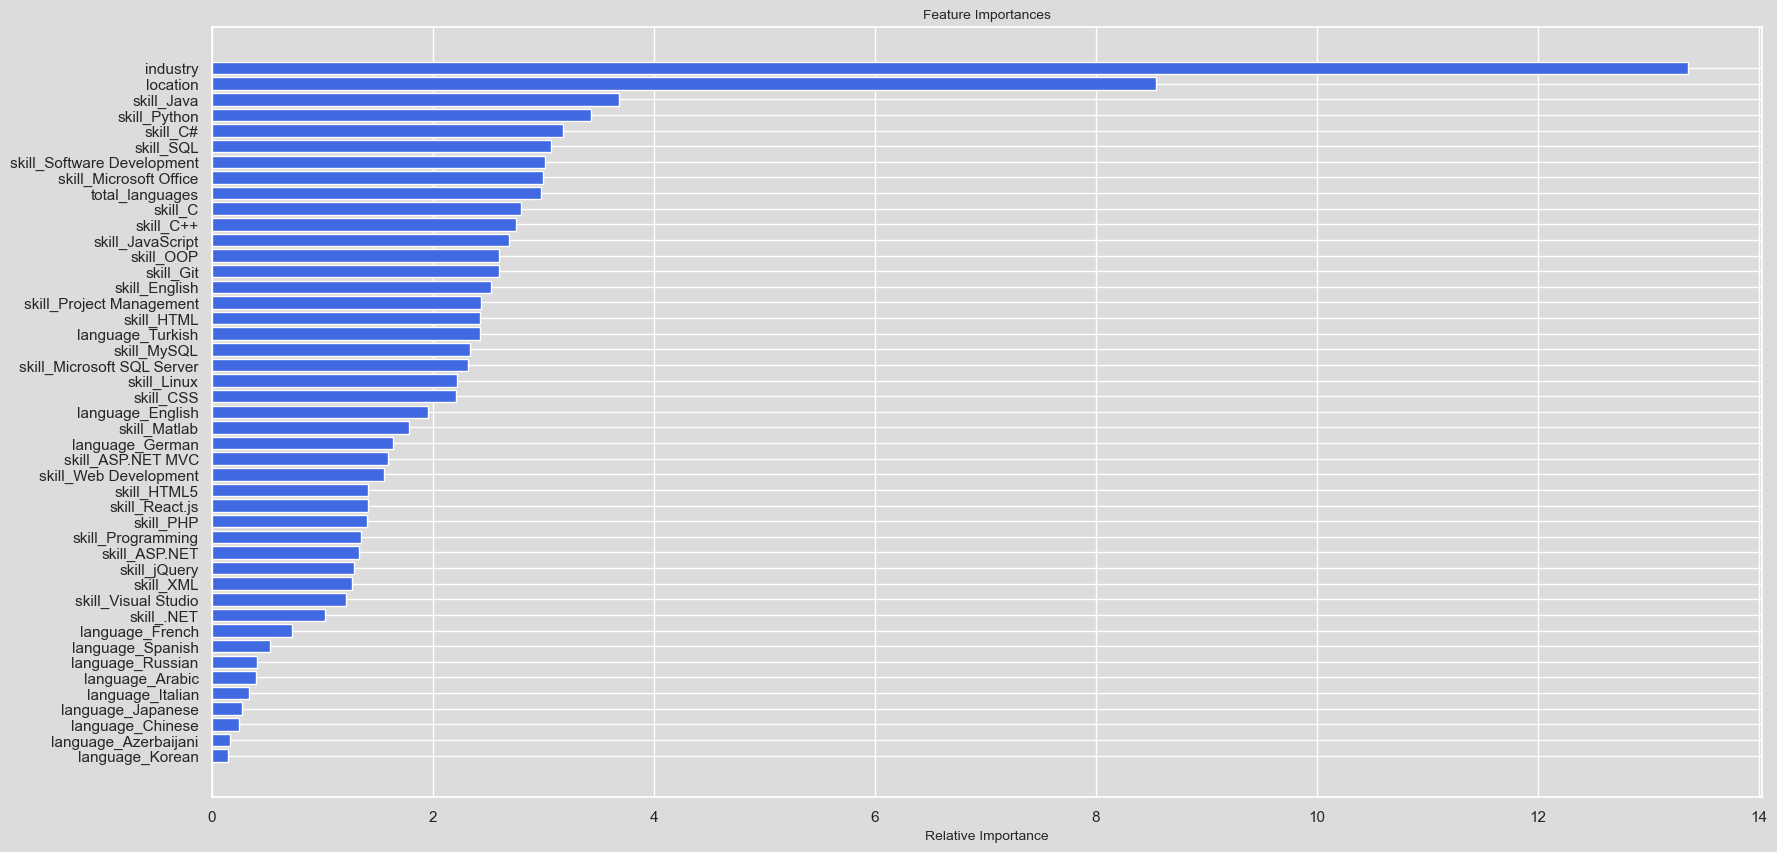

accuracy_score: 0.7199275772320923
-----------------------------------| Fold 4 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6277528	test: 0.6205297	best: 0.6205297 (0)	total: 19.3ms	remaining: 1m 36s
200:	learn: 0.7145735	test: 0.6609325	best: 0.6609325 (200)	total: 2.26s	remaining: 53.9s
400:	learn: 0.7475952	test: 0.6713445	best: 0.6727026 (394)	total: 4.57s	remaining: 52.4s
600:	learn: 0.7696625	test: 0.6781349	best: 0.6783612 (599)	total: 6.87s	remaining: 50.3s
800:	learn: 0.7853926	test: 0.6845858	best: 0.6850385 (754)	total: 9.21s	remaining: 48.3s
1000:	learn: 0.7973202	test: 0.6874151	best: 0.6880942 (984)	total: 11.5s	remaining: 46s
1200:	learn: 0.8081841	test: 0.6902445	best: 0.6902445 (1200)	total: 13.7s	remaining: 43.5s
1400:	learn: 0.8184822	test: 0.6946582	best: 0.6946582 (1398)	total: 16s	remaining: 41.1s
1600:	learn: 0.8274449	test: 0.6964690	best: 0.6979402 (1587)	total: 18.3s	remaining: 38.8s
1800:	learn: 0.8349591	test: 0.6971480	best

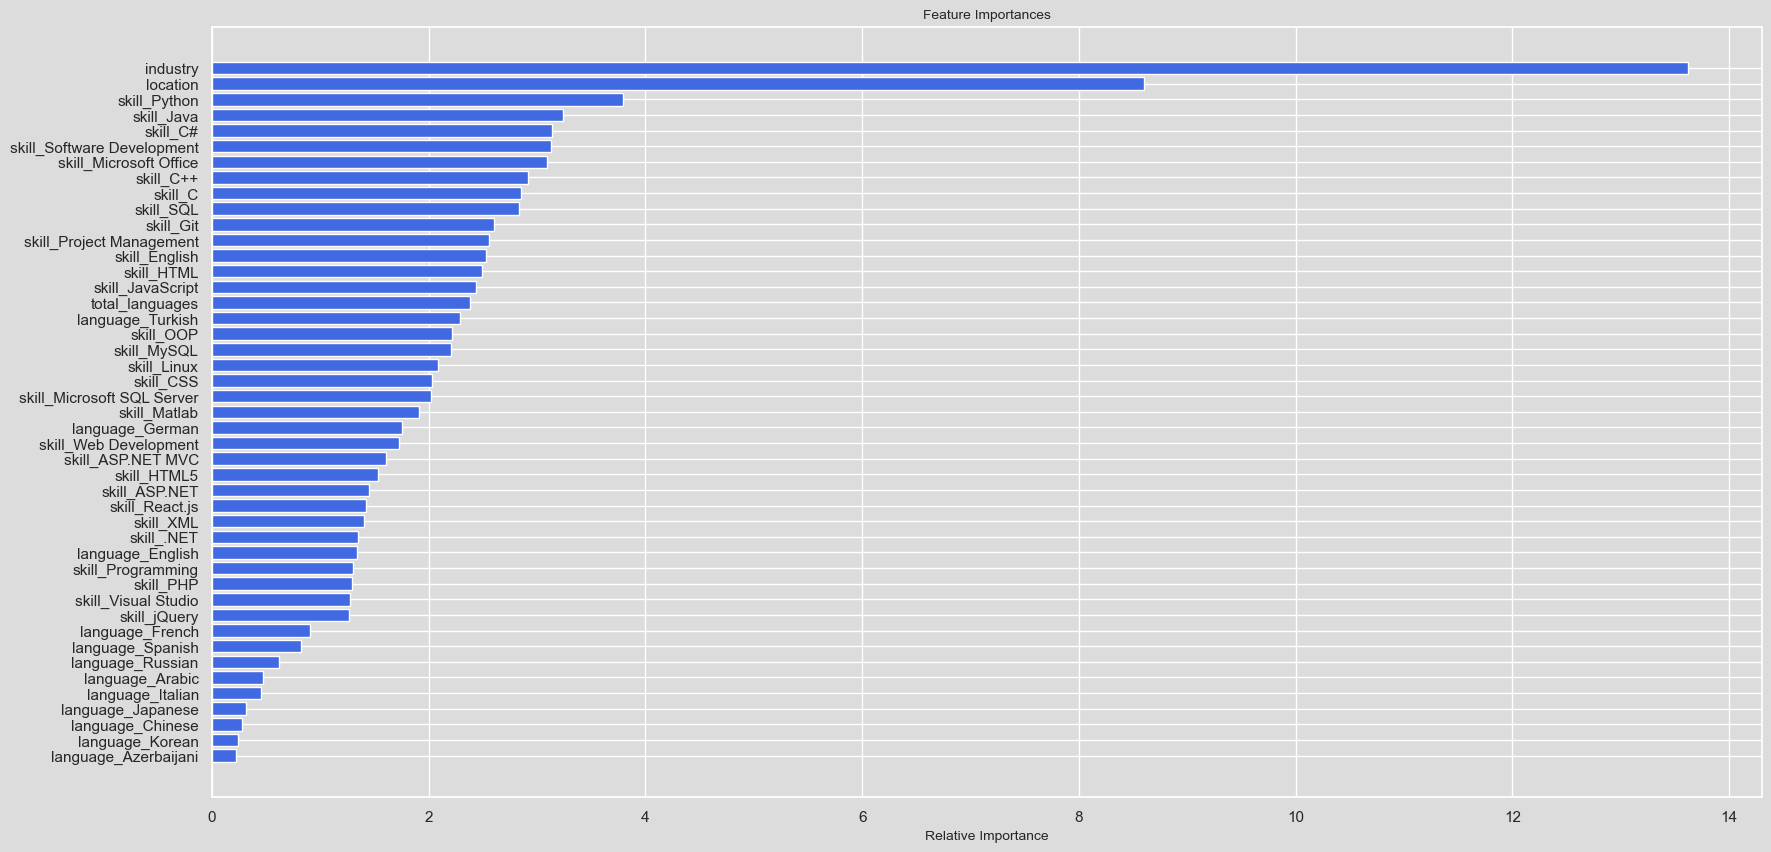

accuracy_score: 0.7050701674966048
-----------------------------------| Fold 5 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6234072	test: 0.6199638	best: 0.6199638 (0)	total: 12ms	remaining: 1m
200:	learn: 0.7152525	test: 0.6583296	best: 0.6587823 (198)	total: 2.29s	remaining: 54.7s
400:	learn: 0.7470068	test: 0.6746265	best: 0.6747397 (397)	total: 4.56s	remaining: 52.3s
600:	learn: 0.7655207	test: 0.6835672	best: 0.6836804 (596)	total: 6.77s	remaining: 49.6s
800:	learn: 0.7792590	test: 0.6870756	best: 0.6875283 (788)	total: 8.99s	remaining: 47.1s
1000:	learn: 0.7928615	test: 0.6889995	best: 0.6904708 (972)	total: 11.2s	remaining: 44.9s
1200:	learn: 0.8052418	test: 0.6949977	best: 0.6955636 (1168)	total: 13.5s	remaining: 42.7s
1400:	learn: 0.8156983	test: 0.6980534	best: 0.6981666 (1375)	total: 15.8s	remaining: 40.6s
1600:	learn: 0.8252269	test: 0.6995247	best: 0.7000905 (1598)	total: 18.1s	remaining: 38.5s
1800:	learn: 0.8350044	test: 0.7023540	best: 

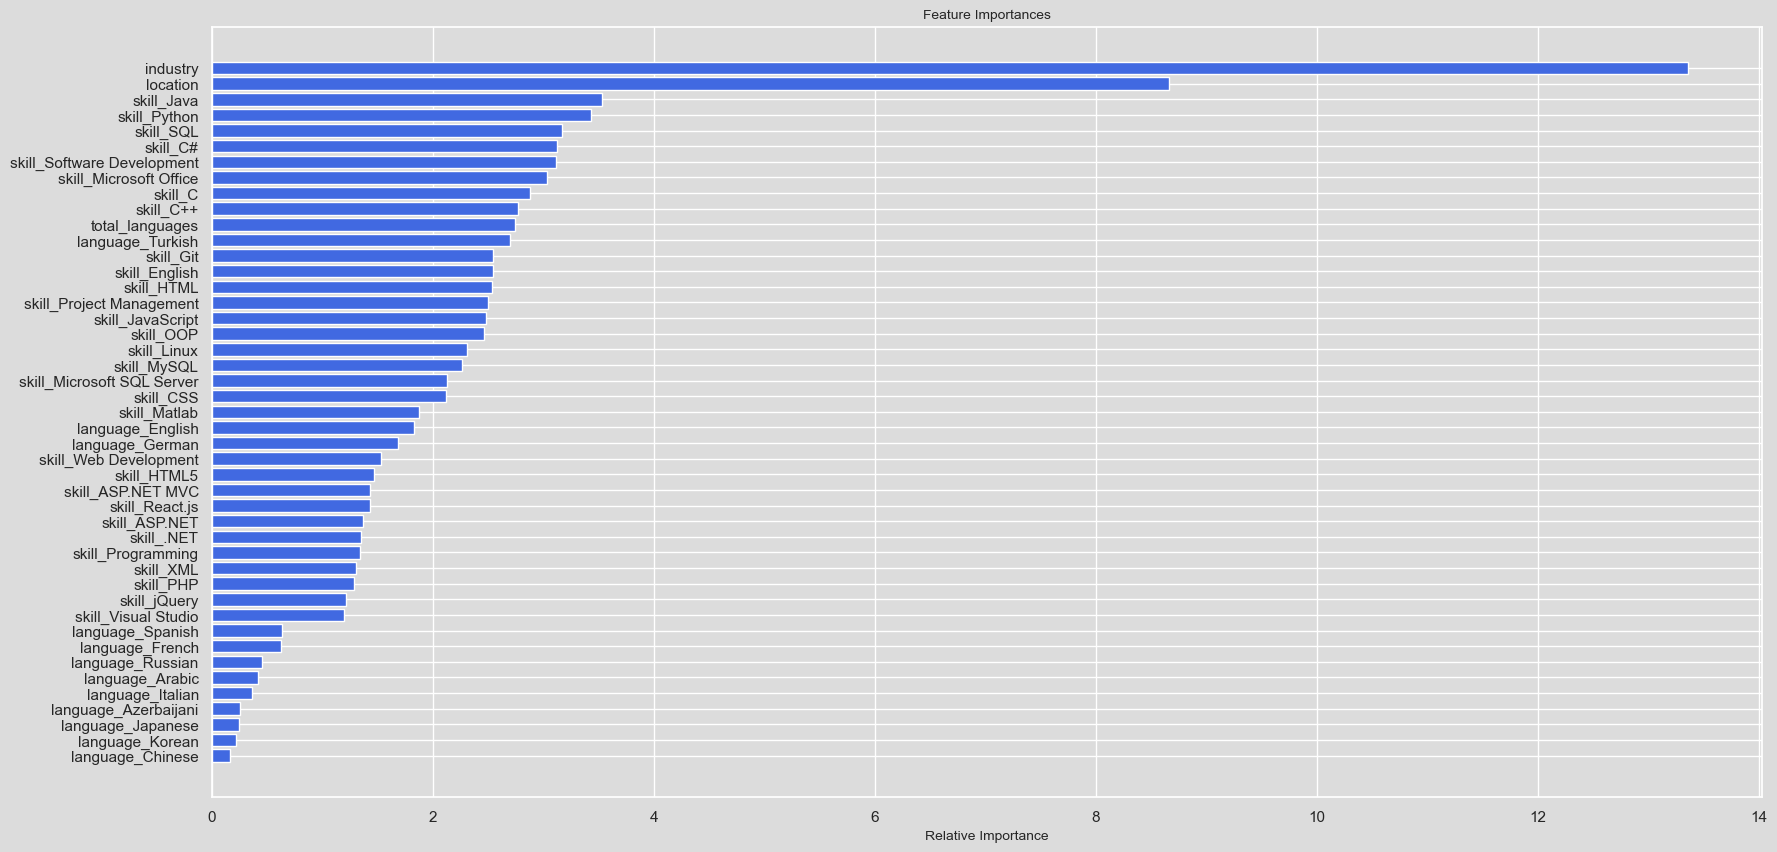

accuracy_score: 0.7205749207786328
-----------------------------------| Fold 6 |-----------------------------------
Learning rate set to 0.040108
0:	learn: 0.6273001	test: 0.6175871	best: 0.6175871 (0)	total: 12.1ms	remaining: 1m
200:	learn: 0.7149356	test: 0.6567451	best: 0.6584427 (179)	total: 2.25s	remaining: 53.8s
400:	learn: 0.7459204	test: 0.6729289	best: 0.6731553 (381)	total: 4.51s	remaining: 51.8s
600:	learn: 0.7677387	test: 0.6805115	best: 0.6811906 (590)	total: 6.74s	remaining: 49.4s
800:	learn: 0.7829708	test: 0.6875283	best: 0.6876415 (799)	total: 8.98s	remaining: 47.1s
1000:	learn: 0.7951248	test: 0.6931870	best: 0.6931870 (999)	total: 11.2s	remaining: 44.9s
1200:	learn: 0.8057624	test: 0.6964690	best: 0.6976007 (1185)	total: 13.6s	remaining: 43s
1400:	learn: 0.8154946	test: 0.6974876	best: 0.6980534 (1369)	total: 15.9s	remaining: 40.8s
1600:	learn: 0.8240726	test: 0.6978271	best: 0.6980534 (1369)	total: 18.2s	remaining: 38.6s
1800:	learn: 0.8327185	test: 0.6988456	best: 

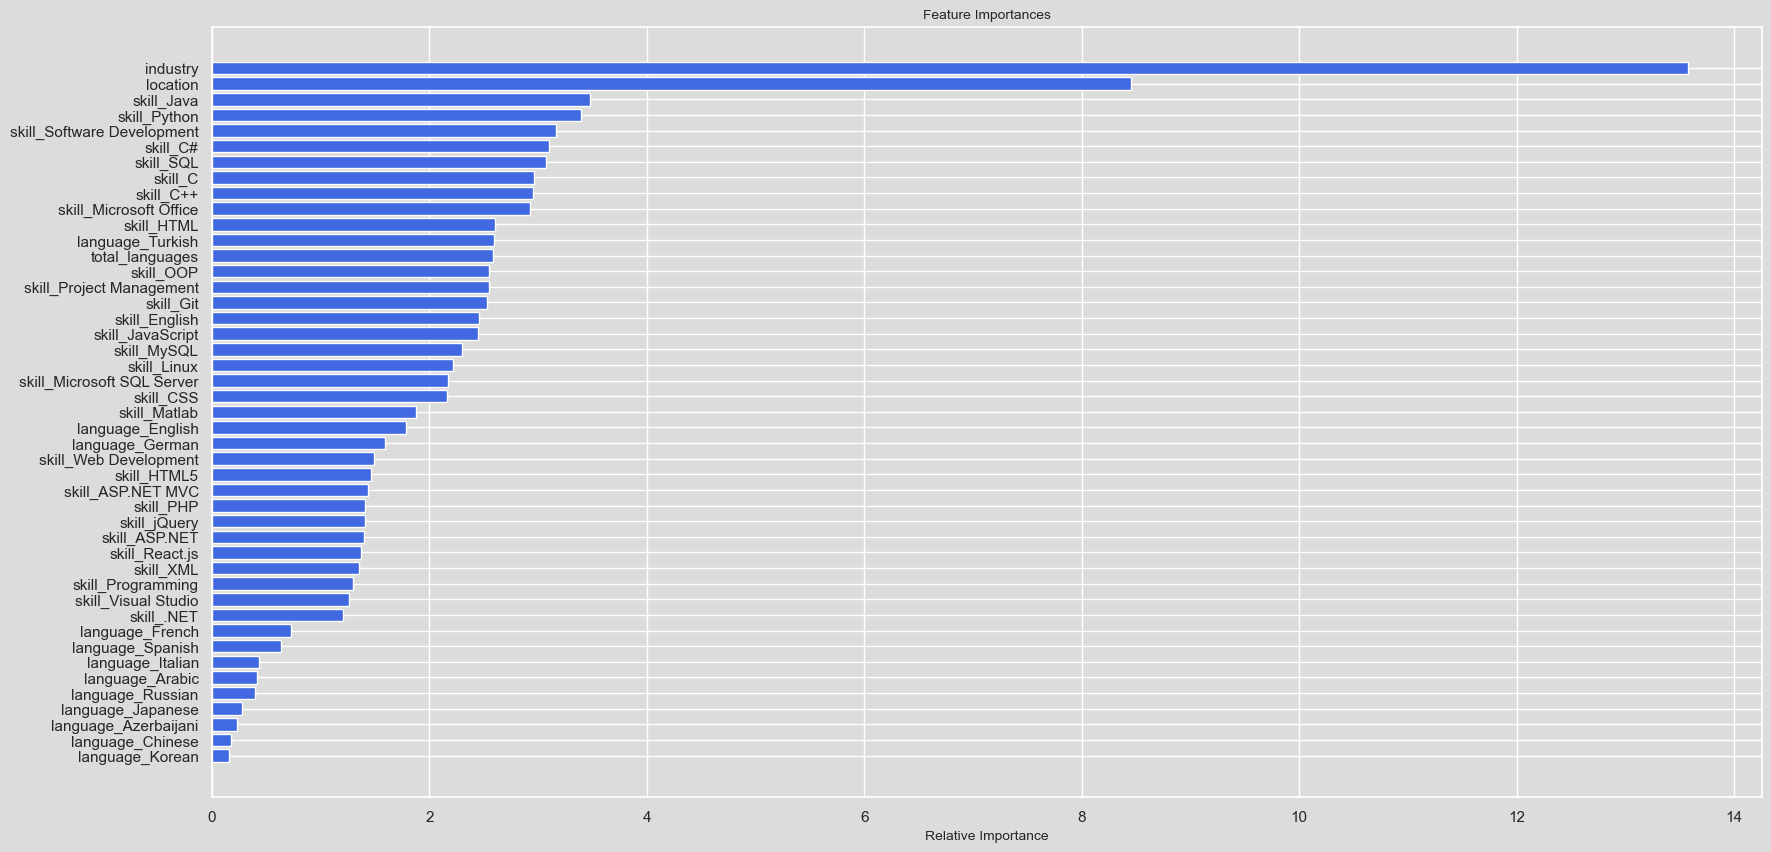

accuracy_score: 0.7171797193300136


In [29]:
for idx, (train_ind, val_ind) in enumerate(kf.split(X, y)):
    print(f"| Fold {idx+1} |".center(80, "-"))
    model = CatBoostClassifier(**params)
    X_train = X.iloc[train_ind]
    y_train = y.iloc[train_ind]
    X_val = X.iloc[val_ind]
    y_val = y.iloc[val_ind]

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=400,
        verbose=200,
    )

    plot_importances(model, features)

    val_pred = model.predict(X_val)
    y_oof[val_ind] += val_pred

    test_pred = model.predict(X_test)
    y_pred += test_pred / config.n_folds

    print(f'accuracy: {accuracy_score(y_val, val_pred)}')
    del X_train, y_train, X_val, y_val
    gc.collect()


In [34]:
sub[target] = np.where(y_pred >= 0.5, 1, 0).tolist()

sub.head()

,user_id,moved_after_2019
0,17449,0
1,33967,0
2,2110,0
3,55082,0
4,37165,0


In [35]:
sub.to_csv(f'../submissions/submission_{"first_oof_training"}.csv', index = False)